In [4]:
import yaml
import numpy as np
import zstandard as zstd
import os
from TraceSimulator import TraceSimulator


import matplotlib.pyplot as plt

def plot_trace_set(trace_set, offset=50):
    """
    Plot a single trace set (shape: 54 x N) with vertical offsets.

    Parameters:
    - trace_set: ndarray, shape (54, N)
    - offset: float, vertical offset between channels
    """
    n_channels, n_samples = trace_set.shape

    for i in range(n_channels):
        color = 'r' if i > 44 else 'b'
        plt.plot(np.arange(n_samples), trace_set[i] + i * offset, color=color, lw=0.2)

    plt.xlabel("Sample Index")
    plt.yticks([])
    plt.ylim(-10, offset * n_channels)
    plt.title("Trace Set")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('../../archive/config.yaml')

ts = TraceSimulator(config)

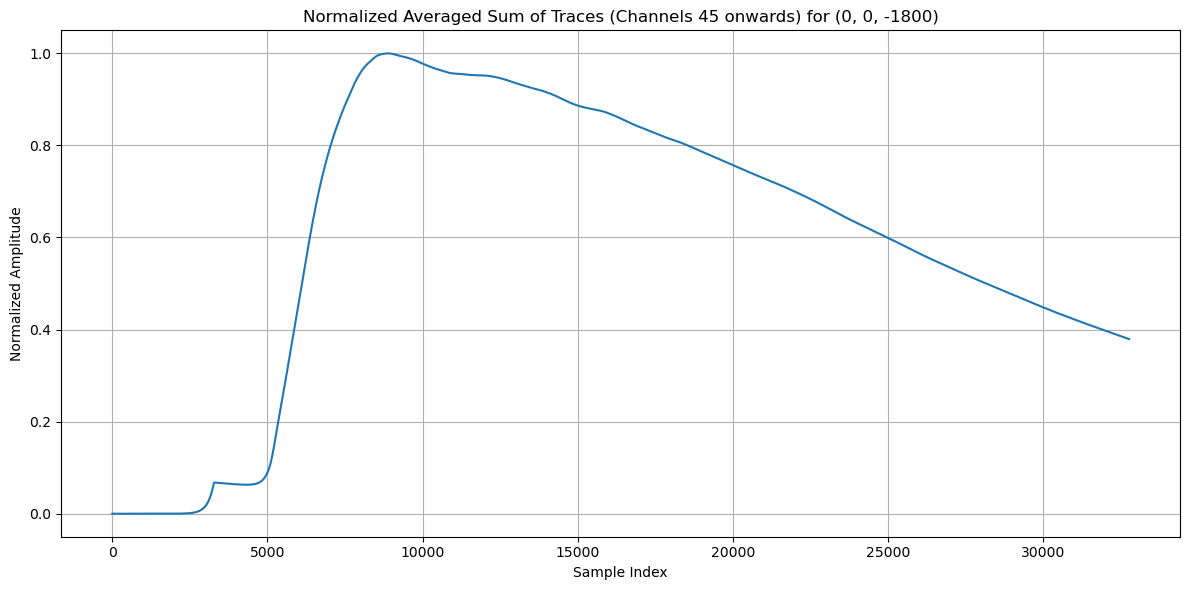

In [2]:
import numpy as np
import matplotlib.pyplot as plt

num_sets = 100
start_channel = 45
Energy = 150

# Generate the first trace to determine shapes
trace =ts.generate(E=Energy, x=0, y=0, z=-1800, no_noise=True, type_recoil='NR', quantize=False, phonon_only=True)
num_channels, num_samples = trace[0].shape

# Preallocate array to hold traces for selected channels
trace_accumulator = np.zeros((num_channels - start_channel, num_samples))

for _ in range(num_sets):
    # Ensure phonon_only=False for the main accumulation loop
    trace = ts.generate(E=Energy, x=0, y=0, z=-1800, no_noise=True, type_recoil='NR', quantize=False, phonon_only=False)
    trace_accumulator += trace[0][start_channel:]

# Average over all sets
avg_traces = trace_accumulator / num_sets

# --- MODIFICATION STARTS HERE ---

# Sum all channels in the averaged trace to get a single combined trace
total_avg_trace = np.sum(avg_traces, axis=0)

# Normalize the single summed trace to its maximum
normalized_total_avg_trace = total_avg_trace / np.max(np.abs(total_avg_trace))

# Plot only the normalized total average trace
plt.figure(figsize=(12, 6))
plt.plot(normalized_total_avg_trace)

plt.title(f"Normalized Averaged Sum of Traces (Channels {start_channel} onwards) for (0, 0, -1800)")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()



Processing traces for z = -1720
Processing traces for z = -1800
Processing traces for z = -1900


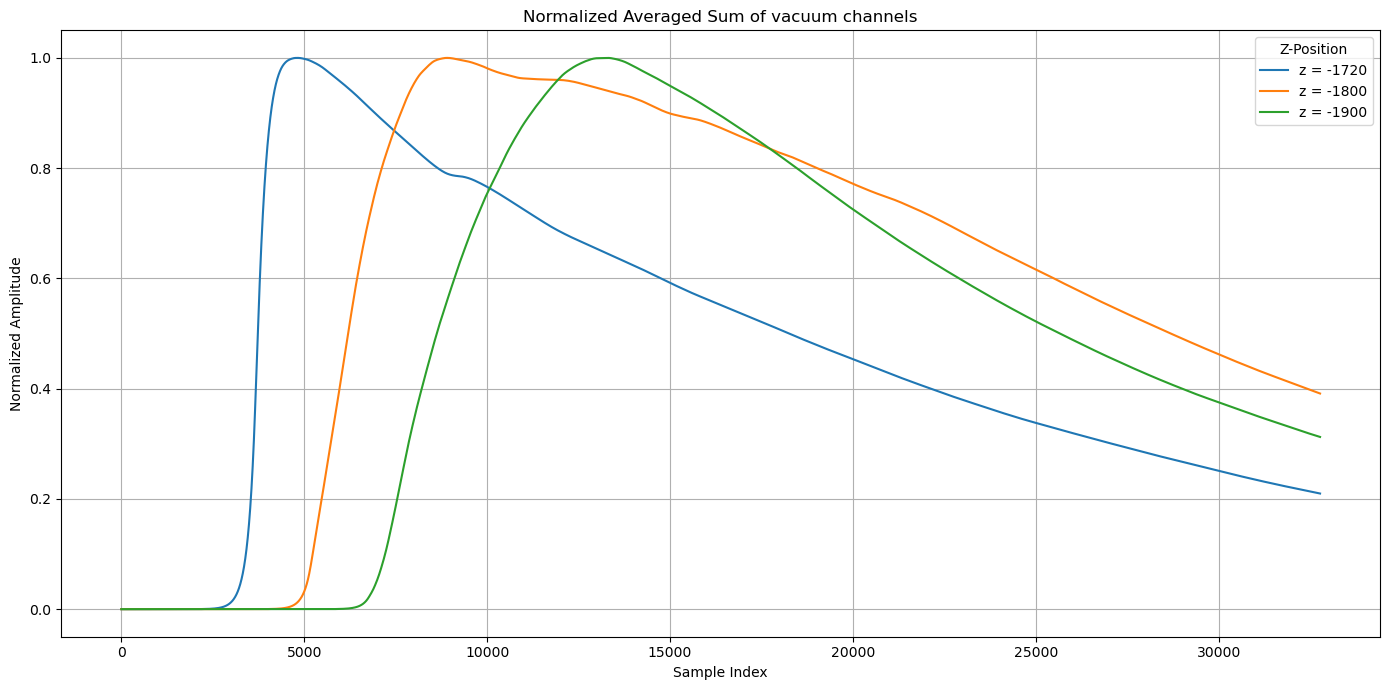

In [3]:
import numpy as np
import matplotlib.pyplot as plt

num_sets = 100
start_channel = 45
Energy = 150

z_values = [-1720, -1800, -1900]

# Dictionary to store the normalized total average traces for each z
normalized_traces_by_z = {}

# Determine shapes once (assuming they are consistent regardless of z or phonon_only=True/False)
# Using one of the z values and phonon_only=True as per original logic for shape determination.
initial_trace_for_shape = ts.generate(E=Energy, x=0, y=0, z=z_values[0], no_noise=True, type_recoil='NR', quantize=False, phonon_only=True)
num_channels, num_samples = initial_trace_for_shape[0].shape

# Loop through each z value to generate and process traces
for z_val in z_values:
    print(f"Processing traces for z = {z_val}")

    # Preallocate array for the current z value
    # Still accumulating from start_channel as per original code
    trace_accumulator = np.zeros((num_channels - start_channel, num_samples))

    for _ in range(num_sets):
        # Generate trace for the current z_val, with no_noise=True, phonon_only=False
        trace = ts.generate(E=Energy, x=0, y=0, z=z_val, no_noise=True, type_recoil='NR', quantize=False, phonon_only=True)
        trace_accumulator += trace[0][start_channel:]

    # Average over all sets for the current z_val
    avg_traces = trace_accumulator / num_sets

    # Sum all channels in the averaged trace to get a single combined trace
    total_avg_trace = np.sum(avg_traces, axis=0)

    # Normalize the single summed trace to its maximum
    # Ensure to handle division by zero if total_avg_trace is all zeros (unlikely for real data)
    max_amp = np.max(np.abs(total_avg_trace))
    if max_amp > 1e-9: # A small threshold to prevent division by near-zero
        normalized_total_avg_trace = total_avg_trace / max_amp
    else:
        normalized_total_avg_trace = total_avg_trace # If flat zero, keep it zero

    # Store the result
    normalized_traces_by_z[z_val] = normalized_total_avg_trace

# Plot all normalized average traces together
plt.figure(figsize=(14, 7))
for z_val, data in normalized_traces_by_z.items():
    plt.plot(data, label=f'z = {z_val}')

plt.title(f"Normalized Averaged Sum of vacuum channels")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Amplitude")
plt.legend(title="Z-Position")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
normalized_traces_by_z[-1800].shape

(32768,)

In [8]:
np.save( "sum_qp_template_1800.npy", normalized_traces_by_z[-1800])

Processing traces for (x, y) = (0, 0)
Processing traces for (x, y) = (94, 0)
Processing traces for (x, y) = (-66.46804, 66.46804)


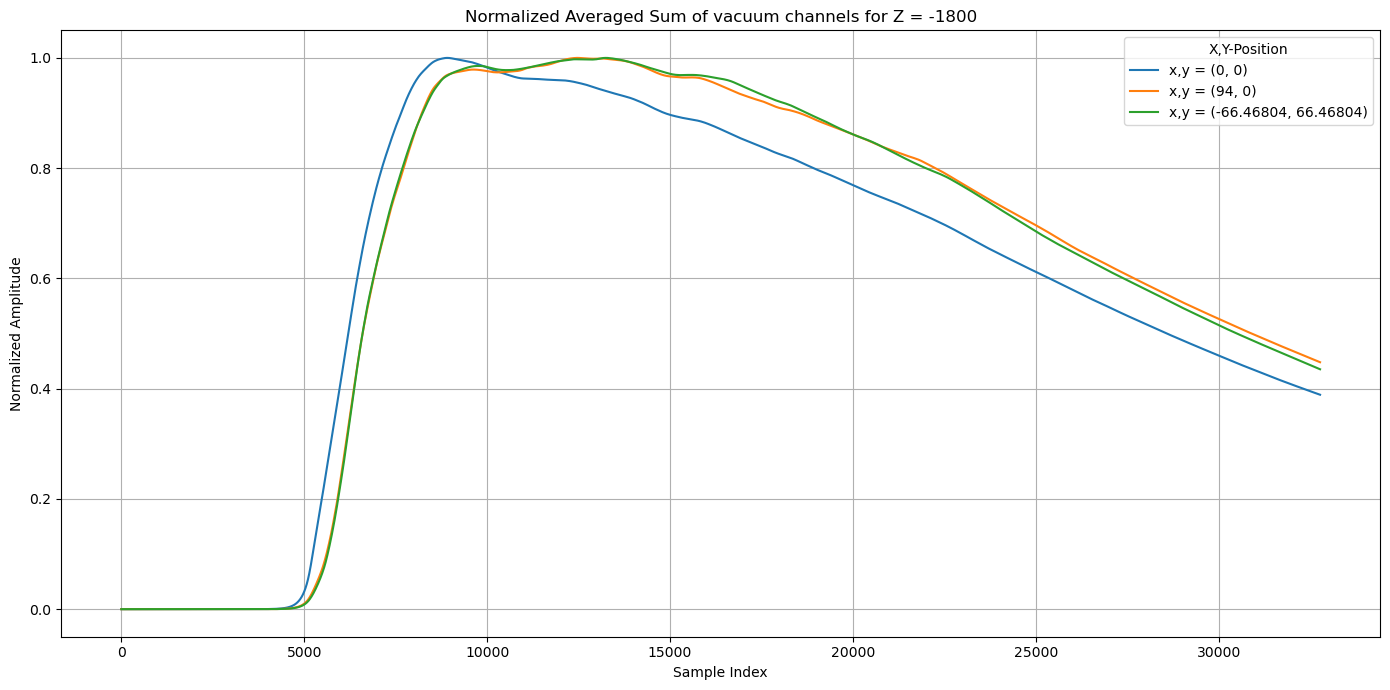

In [15]:
xy_coordinates = [
    (0, 0),
    (94, 0),
    (-66.46804, 66.46804),
]
fixed_z = -1800
Energy = 150

# Dictionary to store the normalized total average traces for each (x, y) set
normalized_traces_by_xy = {}

# Determine shapes once (assuming they are consistent regardless of x, y, or phonon_only=True/False)
# Using one of the (x,y) sets and phonon_only=True as per original logic for shape determination.
initial_trace_for_shape = ts.generate(E=Energy, x=0, y=0, z=fixed_z, no_noise=True, type_recoil='NR', quantize=False, phonon_only=True)
num_channels, num_samples = initial_trace_for_shape[0].shape

# Loop through each (x, y) coordinate set to generate and process traces
for x_val, y_val in xy_coordinates:
    print(f"Processing traces for (x, y) = ({x_val}, {y_val})")

    # Preallocate array for the current (x, y) set
    # Still accumulating from start_channel as per original code
    trace_accumulator = np.zeros((num_channels - start_channel, num_samples))

    for _ in range(num_sets):
        # Generate trace for the current (x, y), fixed z, no_noise=True, phonon_only=False
        trace = ts.generate(E=Energy, x=x_val, y=y_val, z=fixed_z, no_noise=True, type_recoil='NR', quantize=False, phonon_only=True)
        trace_accumulator += trace[0][start_channel:]

    # Average over all sets for the current (x, y)
    avg_traces = trace_accumulator / num_sets

    # Sum all channels in the averaged trace to get a single combined trace
    total_avg_trace = np.sum(avg_traces, axis=0)

    # Normalize the single summed trace to its maximum
    # Ensure to handle division by zero if total_avg_trace is all zeros (unlikely for real data)
    max_amp = np.max(np.abs(total_avg_trace))
    if max_amp > 1e-9: # A small threshold to prevent division by near-zero
        normalized_total_avg_trace = total_avg_trace / max_amp
    else:
        normalized_total_avg_trace = total_avg_trace # If flat zero, keep it zero

    # Store the result, using a formatted string as the key for clarity in printing
    normalized_traces_by_xy[f"({x_val}, {y_val})"] = normalized_total_avg_trace

# Plot all normalized average traces together
plt.figure(figsize=(14, 7))
for xy_label, data in normalized_traces_by_xy.items():
    plt.plot(data, label=f'x,y = {xy_label}')

plt.title(f"Normalized Averaged Sum of vacuum channels for Z = {fixed_z}")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Amplitude")
plt.legend(title="X,Y-Position")
plt.grid(True)
plt.tight_layout()
plt.show()

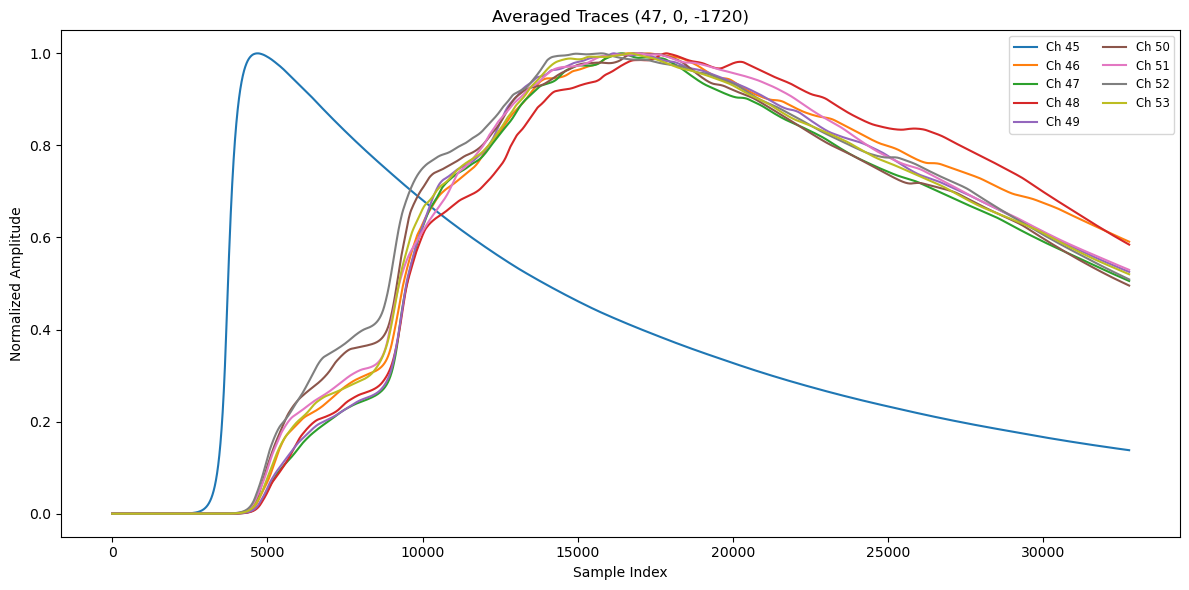

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Configuration
num_sets = 100
start_channel = 45
template_dir = "./"
os.makedirs(template_dir, exist_ok=True)

# Generate first trace to get dimensions
trace, (x, y, z) = ts.generate(E=30000, no_noise=True, type_recoil='NR', quantize=False, phonon_only=False)
num_channels, num_samples = trace[0].shape

# Preallocate for accumulation
trace_accumulator = np.zeros((num_channels - start_channel, num_samples))

# Accumulate traces over multiple sets
for _ in range(num_sets):
    trace = ts.generate(E=30000, x=47, y=0, z=-1720, no_noise=True, type_recoil='NR', quantize=False, phonon_only=True)
    trace_accumulator += trace[0][start_channel:]

# Average the accumulated traces
avg_traces = trace_accumulator / num_sets

# Save channel 45 (i.e., index 0 after slicing) before normalization
template_ch45 = avg_traces[0]

# Normalize traces (all from channel 45 onwards)
normalized_traces = avg_traces / np.max(np.abs(avg_traces), axis=1, keepdims=True)

# Save average of normalized channels 46+ (i.e., index 1 onwards)
template_46plus = np.mean(normalized_traces[1:], axis=0)

# Plotting
plt.figure(figsize=(12, 6))
for i, ch in enumerate(normalized_traces):
    plt.plot(ch, label=f'Ch {start_channel + i}')

plt.title("Averaged Traces (47, 0, -1720)")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Amplitude")
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()


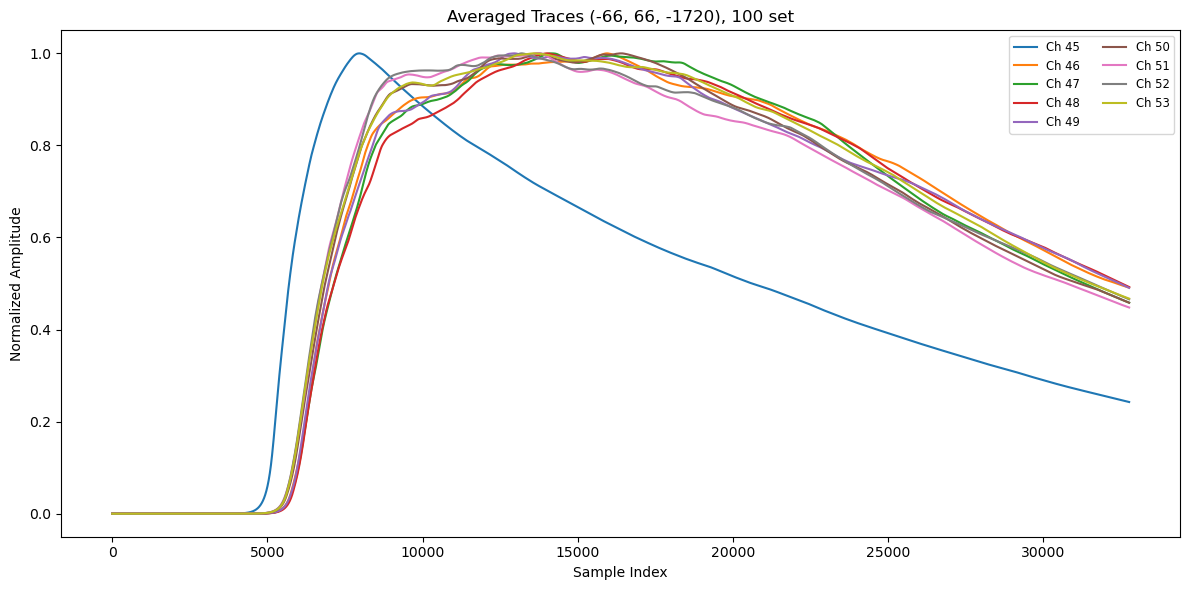

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Configuration
num_sets = 100
start_channel = 45

# Generate first trace to get dimensions
trace = ts.generate(E=300, x=0, y=0, z=-1800, no_noise=True, type_recoil='NR', quantize=False, phonon_only=True)
num_channels, num_samples = trace[0].shape

# Preallocate for accumulation
trace_accumulator = np.zeros((num_channels - start_channel, num_samples))

# Accumulate traces over multiple sets
for _ in range(num_sets):
    trace= ts.generate(E=300, x = 0, y = 0, z =-1800,  no_noise=True, type_recoil='NR', quantize=False, phonon_only=True)
    trace_accumulator += trace[0][start_channel:]

# Average the accumulated traces
avg_traces = trace_accumulator / num_sets


# Normalize traces (all from channel 45 onwards)
normalized_traces = avg_traces / np.max(np.abs(avg_traces), axis=1, keepdims=True)


# Plotting
plt.figure(figsize=(12, 6))
for i, ch in enumerate(normalized_traces):
    plt.plot(ch, label=f'Ch {start_channel + i}')

plt.title("Averaged Traces (-66, 66, -1720), 100 set")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Amplitude")
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()


In [6]:
normalized_traces.shape

(9, 32768)

In [7]:
for i, channel_data in enumerate(normalized_traces):
    # Calculate the original channel number based on the starting index
    original_channel_number = start_channel + i
    np.save(f'channel_{original_channel_number}_normalized_trace.npy', channel_data)



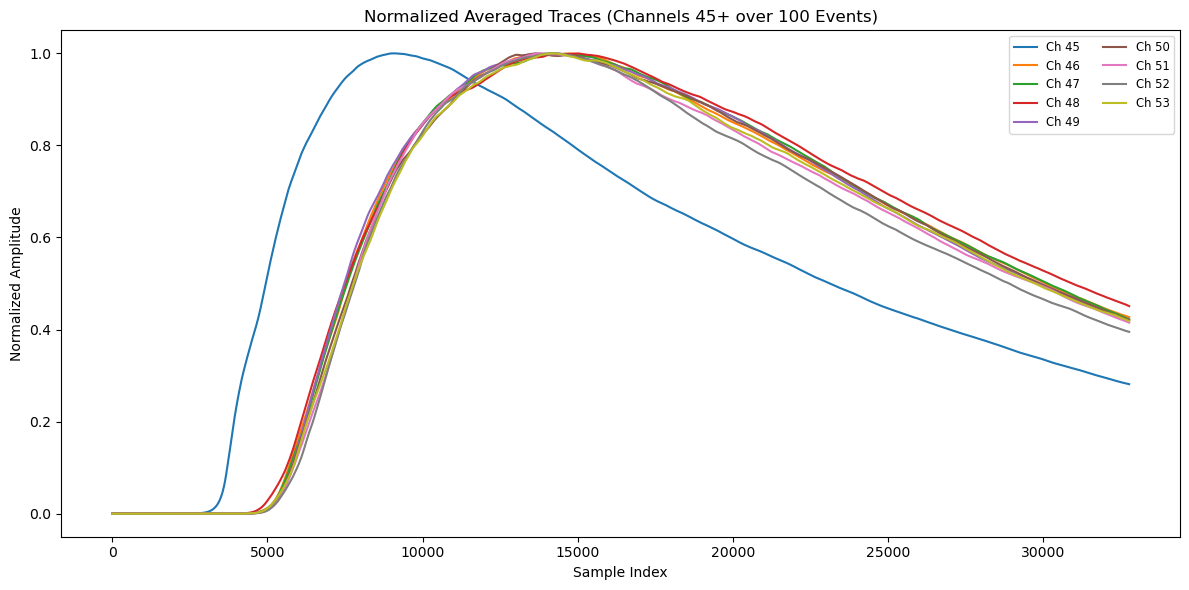

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Configuration
num_sets = 100
start_channel = 45
template_dir = "templates"
os.makedirs(template_dir, exist_ok=True)

# Generate first trace to get dimensions
trace, (x, y, z) = ts.generate(E=30, no_noise=True, type_recoil='NR', quantize=False, phonon_only=False)
num_channels, num_samples = trace[0].shape

# Preallocate for accumulation
trace_accumulator = np.zeros((num_channels - start_channel, num_samples))

# Accumulate traces over multiple sets
for _ in range(num_sets):
    trace, (x, y, z) = ts.generate(E=30, no_noise=True, type_recoil='NR', quantize=False, phonon_only=False)
    trace_accumulator += trace[0][start_channel:]

# Average the accumulated traces
avg_traces = trace_accumulator / num_sets

# Normalize all traces (channel 45 onward)
normalized_traces = avg_traces / np.max(np.abs(avg_traces), axis=1, keepdims=True)

# Save normalized channel 45 (index 0)
template_ch45 = normalized_traces[0]
np.save(os.path.join(template_dir, "vac_ch45_low_eng"), template_ch45)

# Save average of normalized channels 46+
template_46plus = np.mean(normalized_traces[1:], axis=0)
np.save(os.path.join(template_dir, "template_ch46plus_avg.npy"), template_46plus)

# Plotting
plt.figure(figsize=(12, 6))
for i, ch in enumerate(normalized_traces):
    plt.plot(ch, label=f'Ch {start_channel + i}')

plt.title("Normalized Averaged Traces (Channels 45+ over 100 Events)")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Amplitude")
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()


In [1]:
import numpy as np

file_path = '/ceph/bmaier/delight/share/TraceSimulator/acoustic/phonSim_phonTemplate.npz'

# Load with allow_pickle=True in case the file contains objects
data = np.load(file_path, allow_pickle=True)

# List all arrays stored inside
print("Keys in .npz file:")
for key in data.files:
    print(f"  - {key}: shape={data[key].shape}, dtype={data[key].dtype}")

# Optionally inspect one
print("\nExample content (first 1D element) of one key:")
example_key = data.files[0]
print(f"Key: {example_key}")
print(data[example_key][0])


Keys in .npz file:
  - dimension: shape=(8,), dtype=float64
  - data: shape=(9, 12, 15, 15, 25, 101), dtype=float64

Example content (first 1D element) of one key:
Key: dimension
140.0
